# Object Detecion by CNN Regression using Segmentation

## Download data

In [1]:
!wget https://github.com/vladiant/ObjectDetectSamples/raw/main/RegressionCNN/iou_data.csv

--2022-03-19 17:15:24--  https://github.com/vladiant/ObjectDetectSamples/raw/main/RegressionCNN/iou_data.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/RegressionCNN/iou_data.csv [following]
--2022-03-19 17:15:24--  https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/RegressionCNN/iou_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8122039 (7.7M) [text/plain]
Saving to: ‘iou_data.csv’

iou_data.csv        100%[===================>]   7.75M  --.-KB/s    in 0.09s   

2022-03-19 17:15:25 (84.8 MB/s) - ‘iou_data.csv’ saved [8122039/8122

In [2]:
!wget https://github.com/vladiant/ObjectDetectSamples/raw/main/ImageData/Images.zip
!unzip -q Images.zip

--2022-03-19 17:15:25--  https://github.com/vladiant/ObjectDetectSamples/raw/main/ImageData/Images.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/ImageData/Images.zip [following]
--2022-03-19 17:15:25--  https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/ImageData/Images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12680736 (12M) [application/zip]
Saving to: ‘Images.zip’

Images.zip          100%[===================>]  12.09M  --.-KB/s    in 0.1s    

2022-03-19 17:15:25 (114 MB/s) - ‘Images.zip’ saved [12680736/12680736]



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsolutePercentageError

In [6]:
import cv2 as cv
from os import path

## Setup

In [7]:
BATCH_SIZE = 128
IMAGE_SIZE = (32, 32)

Read segmentation data

In [8]:
df = pd.read_csv("iou_data.csv", skipinitialspace=True)
print(f"Data length {len(df)}")

Data length 125901


Shuffle

In [9]:
df = df.sample(frac=1)
split_size = round(len(df)*0.95)
df_val = df[split_size:]
df = df[:split_size]

In [10]:
df.head()

,IOU,x1,x2,y1,y2,filename
10528,0.266851,73,113,145,174,./Images/airplane_409.jpg
40940,0.717457,192,240,228,256,./Images/airplane_183.jpg
19571,0.101811,94,113,193,222,./Images/airplane_362.jpg
43984,0.190083,0,48,124,142,./Images/airplane_376.jpg
10330,0.067467,59,167,0,73,./Images/airplane_531.jpg


In [11]:
def preprocess_image(x):
    # Normalize
    x = tf.cast(x, tf.float32) / 255.0

    # 'RGB'->'BGR'
    x = x[..., ::-1]
    return x

In [12]:
def read_and_prepare_image(image_filename, x1, x2, y1, y2, iou):
    # Get images
    image = tf.io.read_file(image_filename)
    image_decoded = tf.image.rgb_to_grayscale(tf.image.decode_jpeg(image))
 
    # Crop
    image_cropped = image_decoded[y1:y2, x1:x2]
    
    # Resize
    image_resized = tf.image.resize(image_cropped, IMAGE_SIZE)
    
    image_tensor = preprocess_image(image_resized)
    # tf.print(image_tensor)
    
    return image_tensor, iou

In [13]:
def initialize_tf_dataset(data, should_batch = True, should_repeat = True):
    dataset_initial = tf.data.Dataset.from_tensor_slices((data.filename.values,\
                                                          data.x1.values,\
                                                          data.x2.values,\
                                                          data.y1.values,\
                                                          data.y2.values,\
                                                          data.IOU.values,))
    dataset_mapped = dataset_initial.map(read_and_prepare_image)
    dataset_shuffled = dataset_mapped.shuffle(buffer_size = len(data))
    
    if should_batch:
        dataset = dataset_shuffled.batch(BATCH_SIZE)
    else:
        dataset = dataset_shuffled.batch(len(data))
        
    if should_repeat:
        dataset = dataset.repeat()
    return dataset

In [14]:
train_data = initialize_tf_dataset(df)

In [15]:
val_data = initialize_tf_dataset(df_val)

Sample iterator usage:
```
iterator = iter(train_data)
im = iterator.get_next()
tf.print(im[1][0])
plt.imshow(im[0][0], cmap='gray')
```

In [16]:
# https://pyimagesearch.com/2019/01/28/keras-regression-and-cnns/
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [17]:
model = create_cnn(32, 32, 1, regress=True)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640  

In [19]:
model.compile(optimizer=Adam(), loss=MeanAbsolutePercentageError())

In [20]:
history = model.fit(train_data,\
                    epochs = 40,\
                    steps_per_epoch=len(df)//BATCH_SIZE,\
                    validation_data=val_data,
                    validation_steps=len(df_val)//BATCH_SIZE)

Epoch 1/40
934/934 [==============================] - 177s 20ms/step - loss: 221.0592 - val_loss: 98.5936
Epoch 2/40
934/934 [==============================] - 146s 157ms/step - loss: 108.2248 - val_loss: 93.9606
Epoch 3/40
934/934 [==============================] - 146s 156ms/step - loss: 94.9600 - val_loss: 92.1110
Epoch 4/40
934/934 [==============================] - 148s 158ms/step - loss: 94.1477 - val_loss: 92.5650
Epoch 5/40
934/934 [==============================] - 147s 158ms/step - loss: 93.5205 - val_loss: 92.9301
Epoch 6/40
934/934 [==============================] - 148s 158ms/step - loss: 92.4109 - val_loss: 93.4170
Epoch 7/40
934/934 [==============================] - 151s 161ms/step - loss: 92.3710 - val_loss: 90.7590
Epoch 8/40
934/934 [==============================] - 150s 161ms/step - loss: 90.9433 - val_loss: 94.0685
Epoch 9/40
934/934 [==============================] - 149s 159ms/step - loss: 90.3671 - val_loss: 86.1877
Epoch 10/40
934/934 [========================

In [21]:
model.save("regression_segmentation.h5")

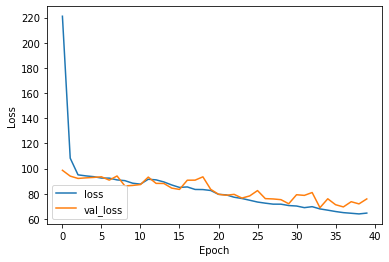

In [22]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

In [23]:
images_path = "./Images"
image = "Planes11.jpg"

In [24]:
image = cv.imread(path.join(images_path,image))
imout = image.copy()

In [25]:
cv.setUseOptimized(True);
ss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [26]:
# Segmentation
ss.setBaseImage(image)
# switchToSelectiveSearchFast, switchToSelectiveSearchQuality, switchToSingleStrategy
ss.switchToSingleStrategy()
ssresults = ss.process()

In [27]:
# Check segments
plane_segments = []
for result in ssresults:
    x,y,w,h = result
    timage = cv.cvtColor(image[y:y+h,x:x+w], cv.COLOR_BGR2GRAY)
    resized = cv.resize(timage,(32,32), interpolation=cv.INTER_CUBIC)
    
    # predict
    tf_image = preprocess_image(tf.convert_to_tensor(resized, dtype=tf.float32))
#     tf.print(tf_image)
#     plt.imshow(tf_image, cmap='gray')
#     break

    images_to_model = np.asarray([tf_image])
    score = model.predict(images_to_model)[0][0]

    # Draw segments with airplanes
    if score > 0.3:
        print(score)
        plane_segments.append((x,y,w,h))
        cv.rectangle(imout,(x,y),(x+w,y+h),(0,255,0),1)

0.34404114
0.35544315
0.6323691
0.48168802
0.39010122
0.5440104
0.46328348
0.38237676
0.38432652
0.42992347
0.56938845
0.31240946
0.63588184
0.30939826
0.70104206
0.4887022
0.46337798
0.39196682
0.32387507
0.35916594
0.30650762
0.6921283
0.38501433
0.47130972
0.70776314


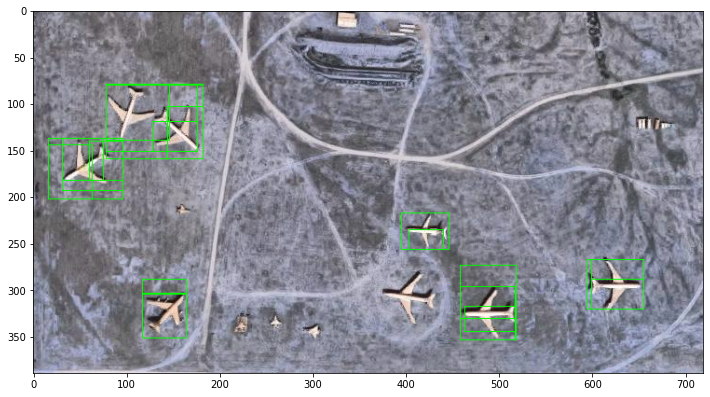

In [28]:
plt.figure(figsize=(12, 10))
plt.imshow(imout)
plt.show()